Epoch [1/50], Train Acc: 59.69%, Val Acc: 69.13%, Train Loss: 1.1570, Val Loss: 0.8674
Epoch [2/50], Train Acc: 73.69%, Val Acc: 73.69%, Train Loss: 0.7502, Val Loss: 0.7574
Epoch [3/50], Train Acc: 78.45%, Val Acc: 75.56%, Train Loss: 0.6211, Val Loss: 0.7014
Epoch [4/50], Train Acc: 81.41%, Val Acc: 79.12%, Train Loss: 0.5357, Val Loss: 0.6007
Epoch [5/50], Train Acc: 83.89%, Val Acc: 81.20%, Train Loss: 0.4639, Val Loss: 0.5394
Epoch [6/50], Train Acc: 85.92%, Val Acc: 82.53%, Train Loss: 0.4055, Val Loss: 0.5254
Epoch [7/50], Train Acc: 87.35%, Val Acc: 83.51%, Train Loss: 0.3599, Val Loss: 0.4865
Epoch [8/50], Train Acc: 88.95%, Val Acc: 83.48%, Train Loss: 0.3160, Val Loss: 0.4787
Epoch [9/50], Train Acc: 90.39%, Val Acc: 82.35%, Train Loss: 0.2773, Val Loss: 0.5608
Epoch [10/50], Train Acc: 91.36%, Val Acc: 84.90%, Train Loss: 0.2479, Val Loss: 0.4607
Epoch [11/50], Train Acc: 92.57%, Val Acc: 84.95%, Train Loss: 0.2149, Val Loss: 0.4741
Epoch [12/50], Train Acc: 92.95%, Val Acc

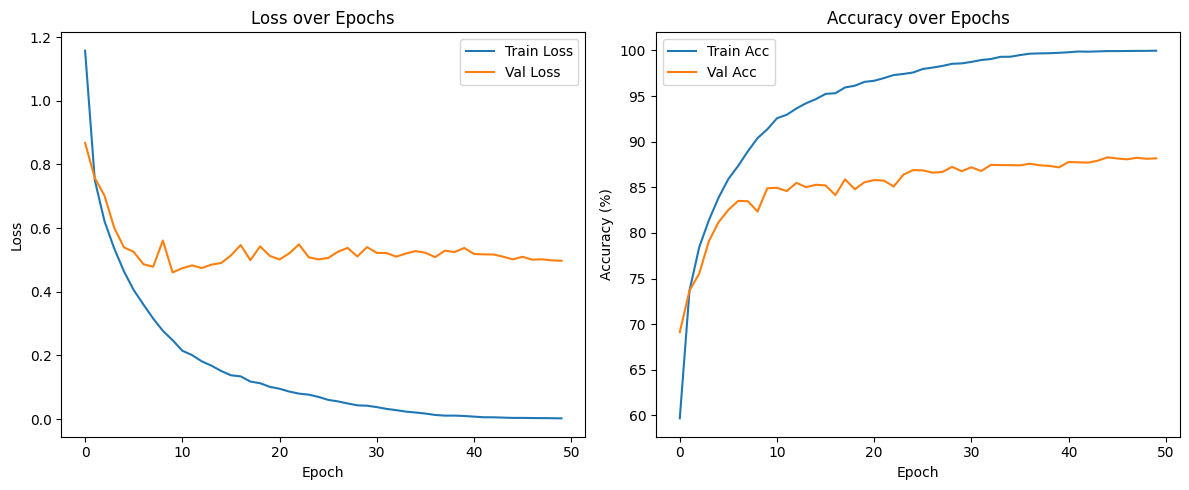

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 50
batch_size = 64
learning_rate = 0.001

# CIFAR-10 transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Classic 9-layer CNN
class ClassicCNN(nn.Module):
    def __init__(self):
        super(ClassicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        return self.classifier(out)

# LSUV Initialization Function
def lsuv_init_fixed(model, data_loader, needed_std=1.0, tolerance=0.1, max_attempts=10):
    model.eval()
    inputs, _ = next(iter(data_loader))
    inputs = inputs.to(device)

    def get_output_hook(storage):
        def hook(module, input, output):
            storage.append(output.clone().detach())
        return hook

    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Step 1: Orthogonal initialization
            nn.init.orthogonal_(layer.weight)

            attempts = 0
            while attempts < max_attempts:
                outputs = []

                hook = layer.register_forward_hook(get_output_hook(outputs))
                _ = model(inputs)
                hook.remove()

                if not outputs:
                    break

                out_std = outputs[0].std().item()
                if abs(out_std - needed_std) < tolerance:
                    break

                layer.weight.data /= (out_std / needed_std)
                attempts += 1

    model.train()

# Load model and initialize with LSUV
model = ClassicCNN().to(device)
lsuv_init_fixed(model, train_loader)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Train the model
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total, correct, train_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss / len(test_loader))

    scheduler.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, "
          f"Train Loss: {train_loss_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}")

duration = time.time() - start_time
print(f"\nTraining completed in {duration:.2f} seconds.")

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
